# Part 6.5 - Analysis Topic Model of ADs
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-02-01 15:25:27


**In this part, we will use the topic modeling result from part 6.1 to analyze the topics of different label (ADs).** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/ads/topicKeys.csv'

df_topics = (pd.read_csv(path, 
                         header=None, 
                         index_col=None, 
                         names = ['topic_', 'weight_', 'keywords_'],
                         encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
0,0,0.001786,apply wanted good post work experience wellington position wages salary office experienced box required applications...
1,1,0.005016,killed police received people london persons hundred men explosion city women injured thousand number arrested wound...
2,2,0.000426,rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...
3,3,0.002292,meeting committee board motion chairman seconded moved thought matter present report carried messrs read resolution ...
4,4,0.002377,sydney south australia melbourne australian wales new_zealand received victoria queensland government federal adelai...


**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/ads/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (841233, 6)


,id,region,year,topic,weight,keywords
97491,3688446,Nelson,1869,85,0.168539,tea advertisements column teas pure quality tobacco coffee b...
459678,15868280,Manawatu-Wanganui,1908,93,0.181654,people country men public government law political state par...
196422,5867097,West Coast,1872,94,0.098478,prices ladies price column advertisements smart wear quality...
316177,9440073,Taranaki,1903,38,0.114787,tin ill oil day lit zealand mil ton tie hat aro fur aid ail ...
371602,11904179,Nelson,1898,148,0.218642,election candidate electors vote party votes candidates elec...


**Average topic weight dataframe:**

In [6]:
path = r'../models/ads/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (20800, 4)


,year,topic,weight,keywords
2289,1850,89,0.002282,sale cattle sheep stock auction horses yards o'clock fat hea...
19559,1939,159,0.013484,london government french british foreign sir news england lo...
5978,1868,178,0.005708,tin tins tea sugar soap jam prices large jars bottle dozen f...
20529,1944,129,0.002348,harness horses sale horse draught farm cart mare plough good...
7645,1877,45,0.005739,goods fancy christmas books stock large xmas prices presents...


## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means the document contains the fewest topics, easy to check the topic by eyes. Most this kind of documents are oversimplified, but it is a simple way to check topics. Here we print the top one of them.**

In [8]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

,id,region,year,topic,weight,keywords
520520,18086539,Wellington,1926,185,0.953162,wellington arrived nelson morning sailed auckland tons to-mo...
175918,5365797,Nelson,1873,169,0.925254,war great germany british peace german world britain people ...
275970,8113264,Taranaki,1885,55,0.920173,sale stock goods prices cash great advertisements price colu...


In [9]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

18086539

In [10]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 18086539
1783807:18086539	Page 2 Advertisements Column 5	"J)E LUXE COMMENCING FRIDAY NEXT! THE MIGHTY WILLIAM FOX EPIC OF THE SCREEN. HAVO4 HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC! HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC\" HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC HAVOC rr ' HAVOC HAVOC HAVO

## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the hightest weight 20 topics in topics list.**

In [11]:
df_plt = df_topics.copy(deep=True).sort_values(by='weight')

def addWeight(keywords):
    k = keywords.split()
    s = sum(range(len(k)+1))
    v = [i / s for i in range(len(k), 0, -1)]
    return dict(zip(k, v))

df_plt['cloudwords'] = df_plt['keywords'].map(addWeight)

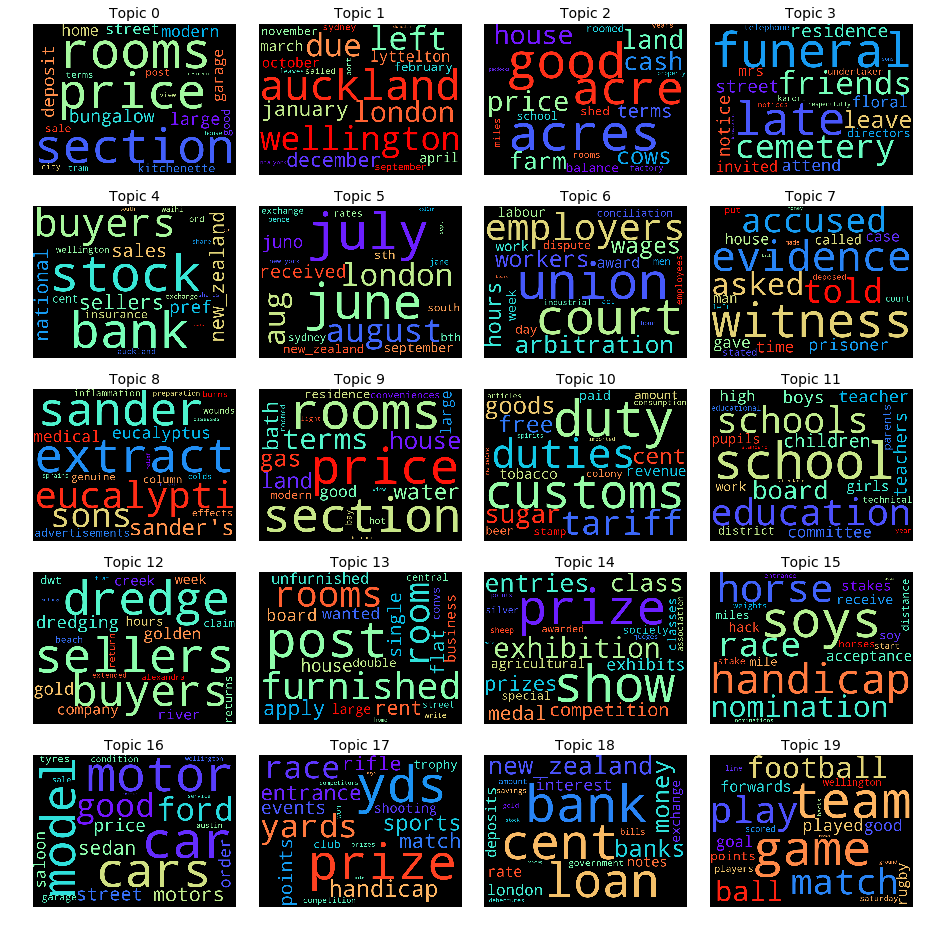

In [12]:
#show_num_topics = df_plt.shape[0]
plt_topics = 20
plt_words  = 20
plt_cols   = 4

cloud = WordCloud(width=800,
                  height=600,
                  max_words=plt_words,
                  colormap='rainbow')

fig, axes = plt.subplots(int(plt_topics/4), plt_cols,
                         figsize=(13,13), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(df_plt.iloc[i]['cloudwords'],
                                    max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic {}'.format(i), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.2 Documents Distribution

**Before checking the topic distribution, we should take a look at the documents distribution.**

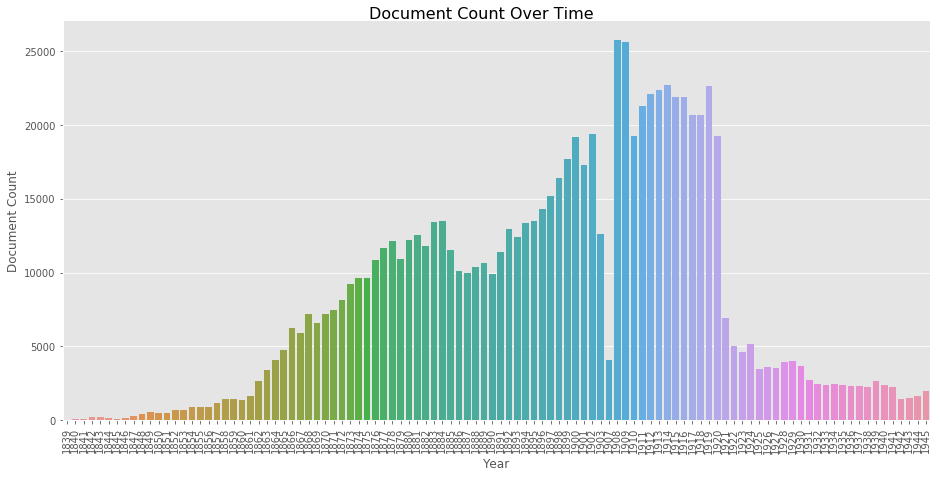

In [13]:
g = sns.catplot(x="year",
                kind='count', height=6.5, aspect=2, 
                dodge=False, legend=False, 
                data=df_domtopic)
g.fig.suptitle("Document Count Over Time", fontsize=16)
g.fig.subplots_adjust(top=0.95)
g.set(xlabel='Year', ylabel='Document Count')        
g.set_xticklabels(rotation=90, step=1)

### 3.3 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general.**

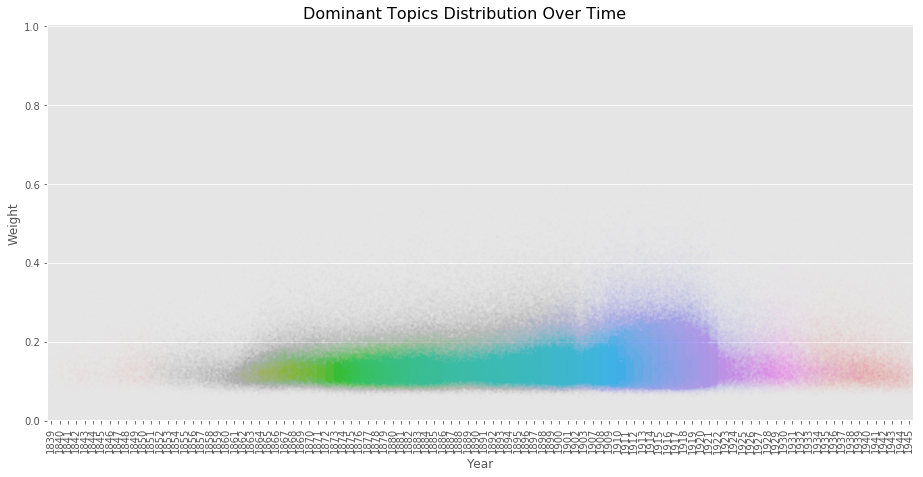

In [14]:
g = sns.catplot(x="year", y='weight',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=3, alpha=0.005,
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Time", fontsize=16)
g.set(xlabel='Year', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 3.4 Annual Average Weight Distribution

**We plot all the annual average weight to see the general distribution:**

In [15]:
df_plt = df_avgweight[['year', 'topic', 'weight']]

df_plt = pd.pivot_table(data=df_plt,
                        index='topic',
                        values='weight',
                        columns='year')
scaler = MinMaxScaler()
df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt),columns = df_plt.columns)
df_plt.head()

year,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945
topic,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000307,0.001178,0.001007,0.001155,0.002365,0.000349,0.004554,0.000570,0.002509,0.003698,0.002016,0.001623,0.001558,0.001661,0.002925,0.001427,0.000703,0.001275,0.001288,0.001237,0.002060,0.001496,0.001464,0.001004,0.001014,0.000968,0.001229,0.000897,0.001009,0.001269,0.001057,0.000855,0.001309,0.001507,0.001349,0.001382,0.000982,0.001060,0.001194,0.001229,0.001293,0.001602,0.001253,0.001162,0.001385,0.001263,0.001273,0.001485,0.001389,0.001525,0.001276,0.001642,0.001721,0.001732,0.001911,0.001761,0.001841,0.001941,0.002058,0.001876,0.001528,0.001613,0.001507,0.001454,0.001425,0.001760,0.001661,0.001464,0.001851,0.001593,0.001597,0.001803,0.001844,0.001869,0.001851,0.002023,0.002290,0.002365,0.002367,0.002574,0.002630,0.002666,0.002997,0.003748,0.003181,0.003636,0.004241,0.003687,0.004648,0.004714,0.003197,0.002159,0.002620,0.002827,0.002740,0.002612,0.003142,0.004315,0.004410,0.004505,0.005087,0.003862,0.003454,0.005415
1,0.012656,0.009324,0.008173,0.005256,0.003049,0.005601,0.007255,0.004706,0.006127,0.006480,0.004756,0.004308,0.003519,0.005227,0.004957,0.004353,0.004257,0.004384,0.004384,0.003385,0.005064,0.004414,0.005111,0.005598,0.006072,0.005721,0.005758,0.005945,0.006029,0.006771,0.006354,0.005600,0.006906,0.005820,0.006008,0.006055,0.005634,0.006200,0.005489,0.005719,0.005413,0.005451,0.005479,0.005882,0.004892,0.004834,0.004741,0.004611,0.005509,0.005578,0.005169,0.004809,0.004262,0.004147,0.003744,0.004044,0.004402,0.004178,0.004254,0.004332,0.004694,0.004617,0.004241,0.004437,0.004257,0.005562,0.004959,0.005206,0.004819,0.004832,0.004676,0.004922,0.004955,0.004648,0.004900,0.004521,0.004885,0.004972,0.005317,0.004635,0.005204,0.005464,0.005459,0.005779,0.005565,0.004481,0.006146,0.005282,0.005045,0.005039,0.004614,0.005766,0.005379,0.005259,0.005705,0.004899,0.006278,0.006024,0.006229,0.006608,0.006967,0.005275,0.005190,0.004884
2,0.000004,0.001916,0.000025,0.000022,0.000059,0.000015,0.000298,0.000111,0.000077,0.000030,0.000062,0.000077,0.000140,0.000167,0.000252,0.000097,0.000187,0.000147,0.000178,0.000165,0.000279,0.000231,0.000178,0.000134,0.000119,0.000110,0.000179,0.000261,0.000211,0.000119,0.000159,0.000427,0.000174,0.000228,0.000225,0.000230,0.000140,0.000198,0.000193,0.000318,0.000278,0.000347,0.000417,0.000197,0.000372,0.000368,0.000416,0.000276,0.000276,0.000357,0.000460,0.000268,0.000337,0.000301,0.000298,0.000307,0.000292,0.000330,0.000401,0.000424,0.000442,0.000585,0.000368,0.000362,0.000385,0.000396,0.000358,0.000432,0.000579,0.000444,0.000549,0.000515,0.000464,0.000478,0.000589,0.000582,0.000624,0.000554,0.000561,0.000582,0.000414,0.000610,0.000451,0.000474,0.000569,0.000486,0.000889,0.000791,0.000985,0.000744,0.000663,0.000692,0.000552,0.000916,0.001531,0.001203,0.001917,0.001686,0.000970,0.001008,0.000872,0.000482,0.000777,0.000589
3,0.004961,0.004883,0.001128,0.001443,0.001758,0.004271,0.001189,0.001009,0.001370,0.001013,0.001909,0.001053,0.000725,0.001577,0.001837,0.001540,0.001253,0.003466,0.001073,0.001852,0.001723,0.001458,0.001738,0.001367,0.001888,0.001857,0.001525,0.001865,0.002363,0.002550,0.002500,0.002378,0.002259,0.002195,0.001947,0.002343,0.002230,0.002395,0.002107,0.002259,0.002751,0.002562,0.002278,0.002011,0.001957,0.002409,0.002341,0.002385,0.002761,0.002350,0.002150,0.002071,0.002241,0.002143,0.002093,0.002144,0.001739,0.001900,0.002037,0.002169,0.001887,

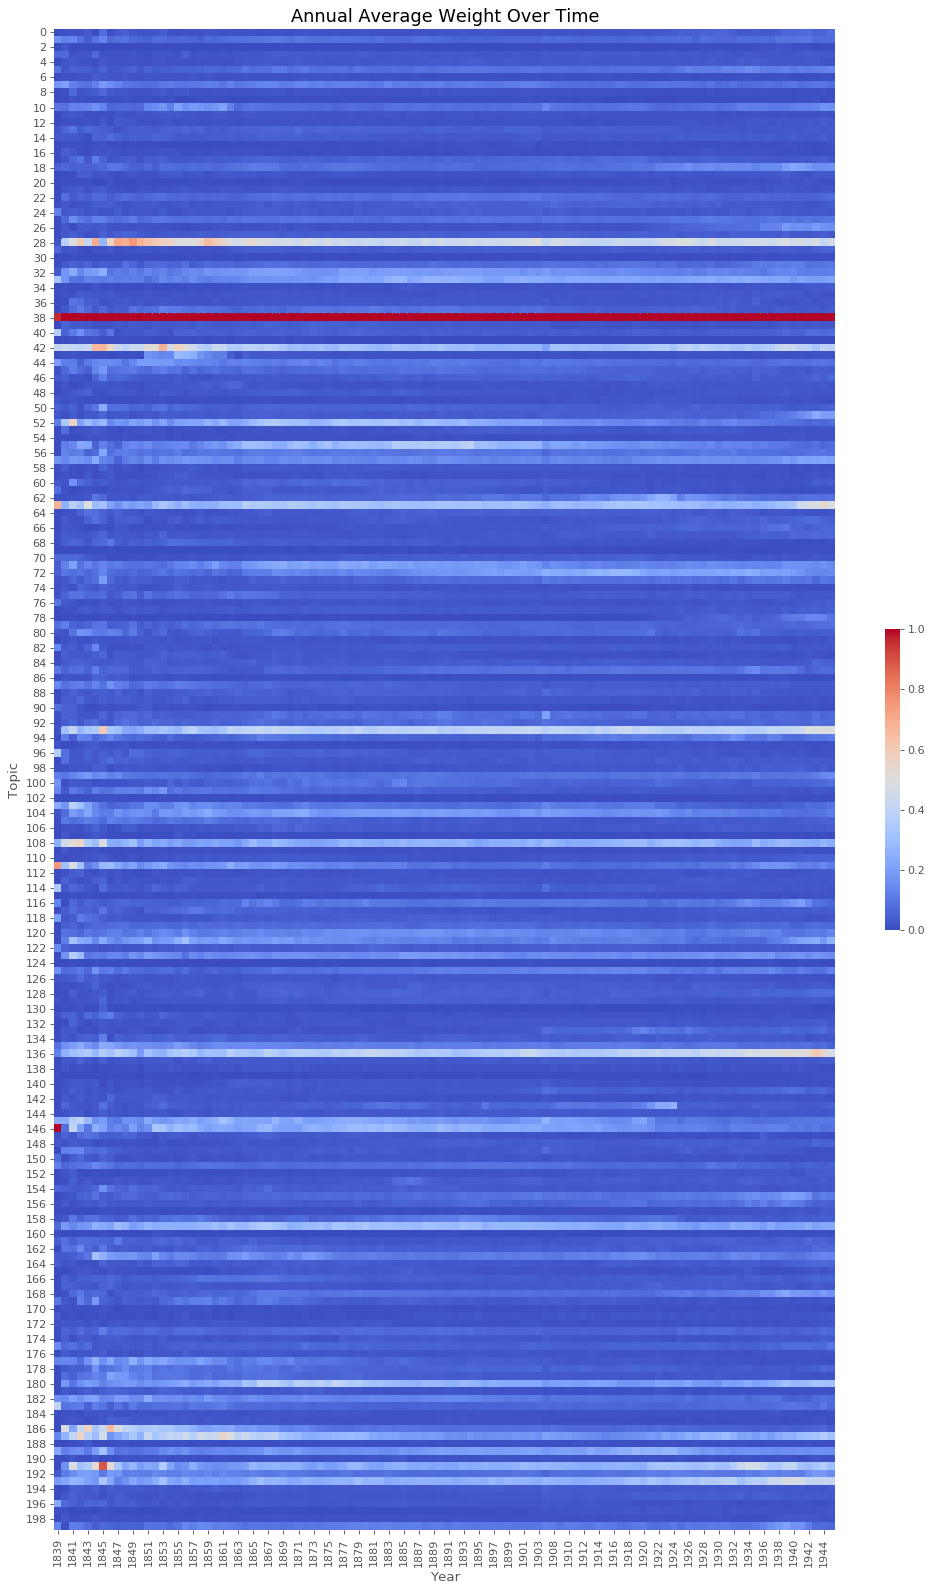

In [16]:
fig, ax = plt.subplots(figsize=(13, 20), dpi=dpi)

sns.heatmap(df_plt_scaled,
            cmap='coolwarm',
            cbar=True,
            cbar_kws={"shrink": .2},
            annot=False,
            square=True,
            ax=ax
            )

plt.xlabel('Year')
plt.ylabel('Topic')
plt.title("Annual Average Weight Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

### 3.5 Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

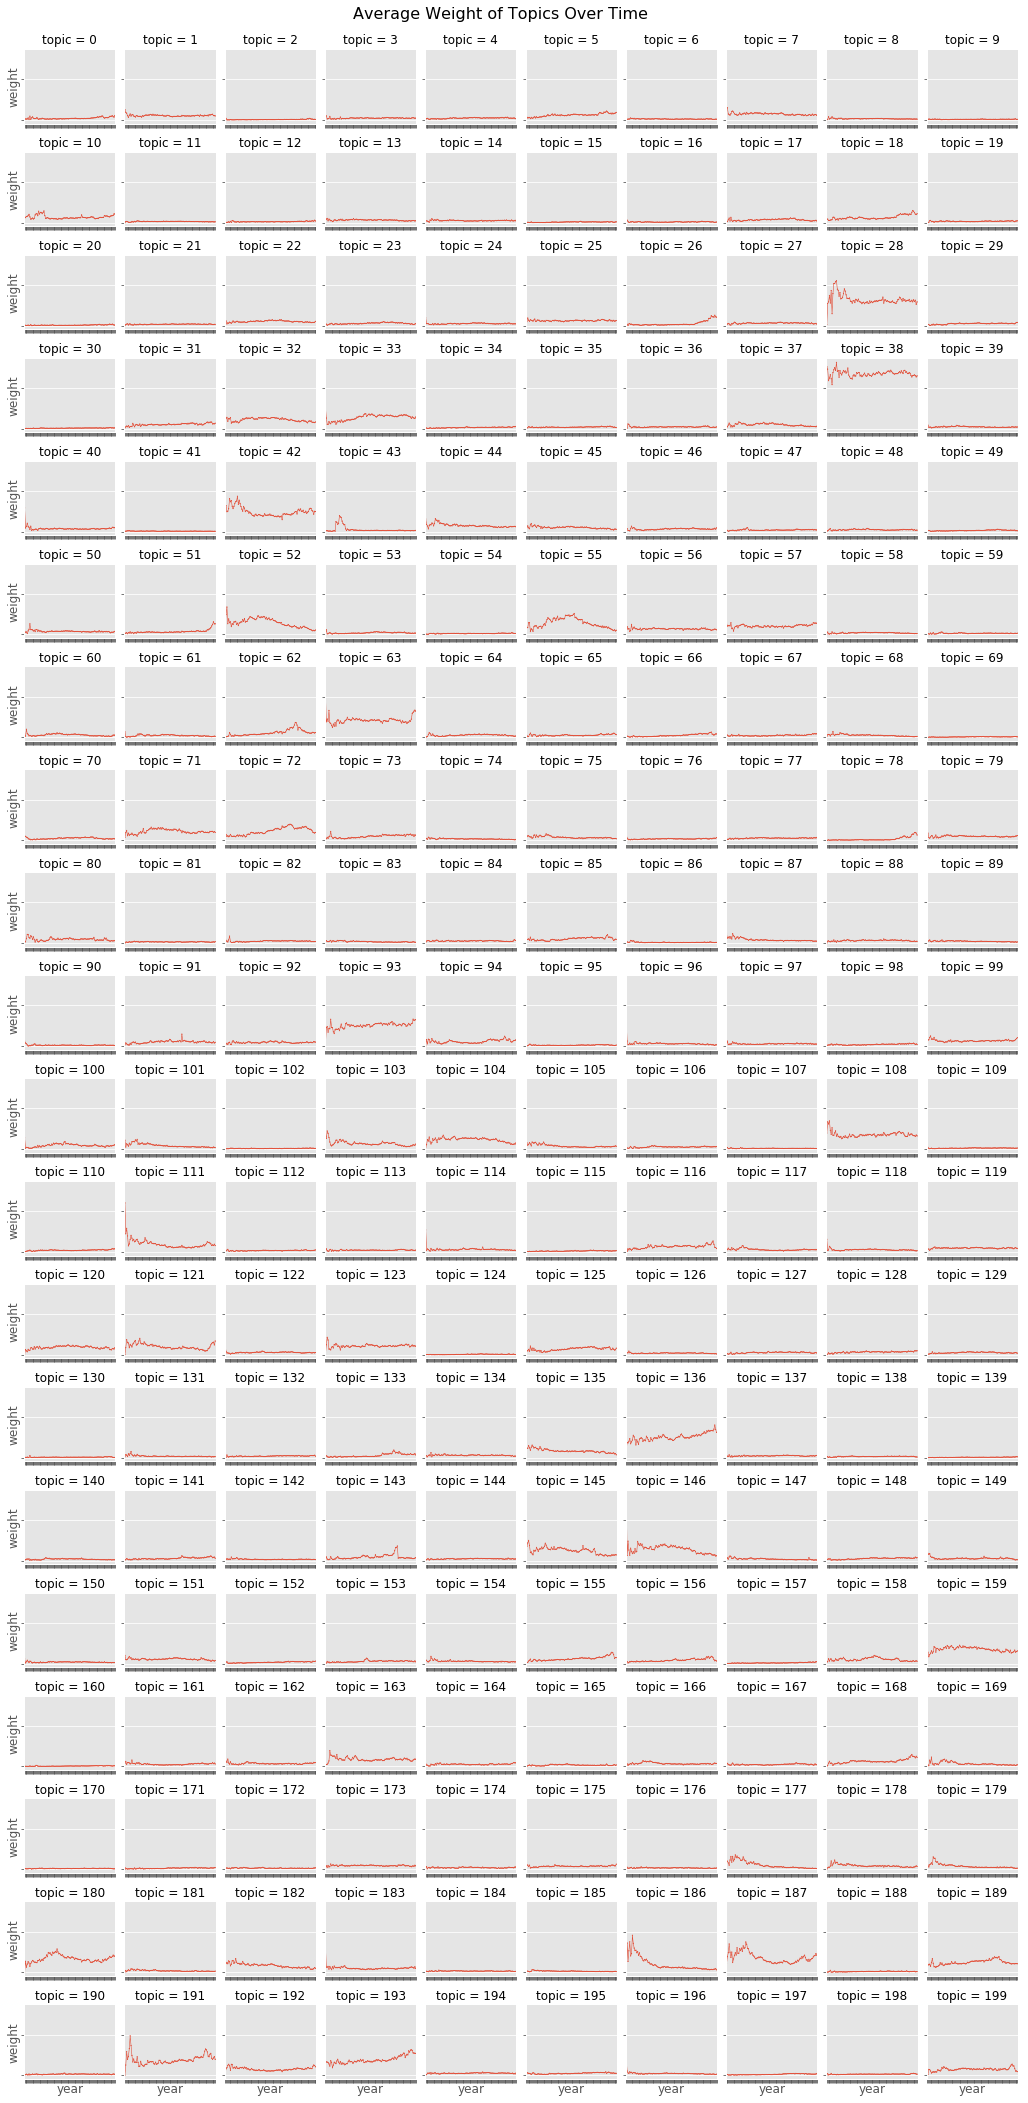

In [17]:
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_avgweight)
g.fig.suptitle("Average Weight of Topics Over Time", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.1)

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

**Generate dominant topics dataframe for plot:**

In [18]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape of df_plt_dom: (7545, 6)
Shape of df_plt_avg: (1040, 4)


,weight,keywords
topic,,
0,0.001786,apply wanted good post work experience wellington position wages salary office experienced box required applications...
1,0.005016,killed police received people london persons hundred men explosion city women injured thousand number arrested wound...
2,0.000426,rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...
3,0.002292,meeting committee board motion chairman seconded moved thought matter present report carried messrs read resolution ...
4,0.002377,sydney south australia melbourne australian wales new_zealand received victoria queensland government federal adelai...
5,0.006192,chinese china japanese japan russia russian turkish troops british turkey received government war constantinople lon...
6,0.001035,yds prize yards race handicap sports entrance match rifle points events shooting trophy club competition won prizes ...
7,0.007151,handicap lady furlongs meeting miles mile hack soys king acceptances miss cup gold sir bst royal hurdles day rose club
8,0.001431,reward lost ost white found dog finder apply notice black branded person bay return pound returning office gold satu...


**Dominant topics distribution by year:**

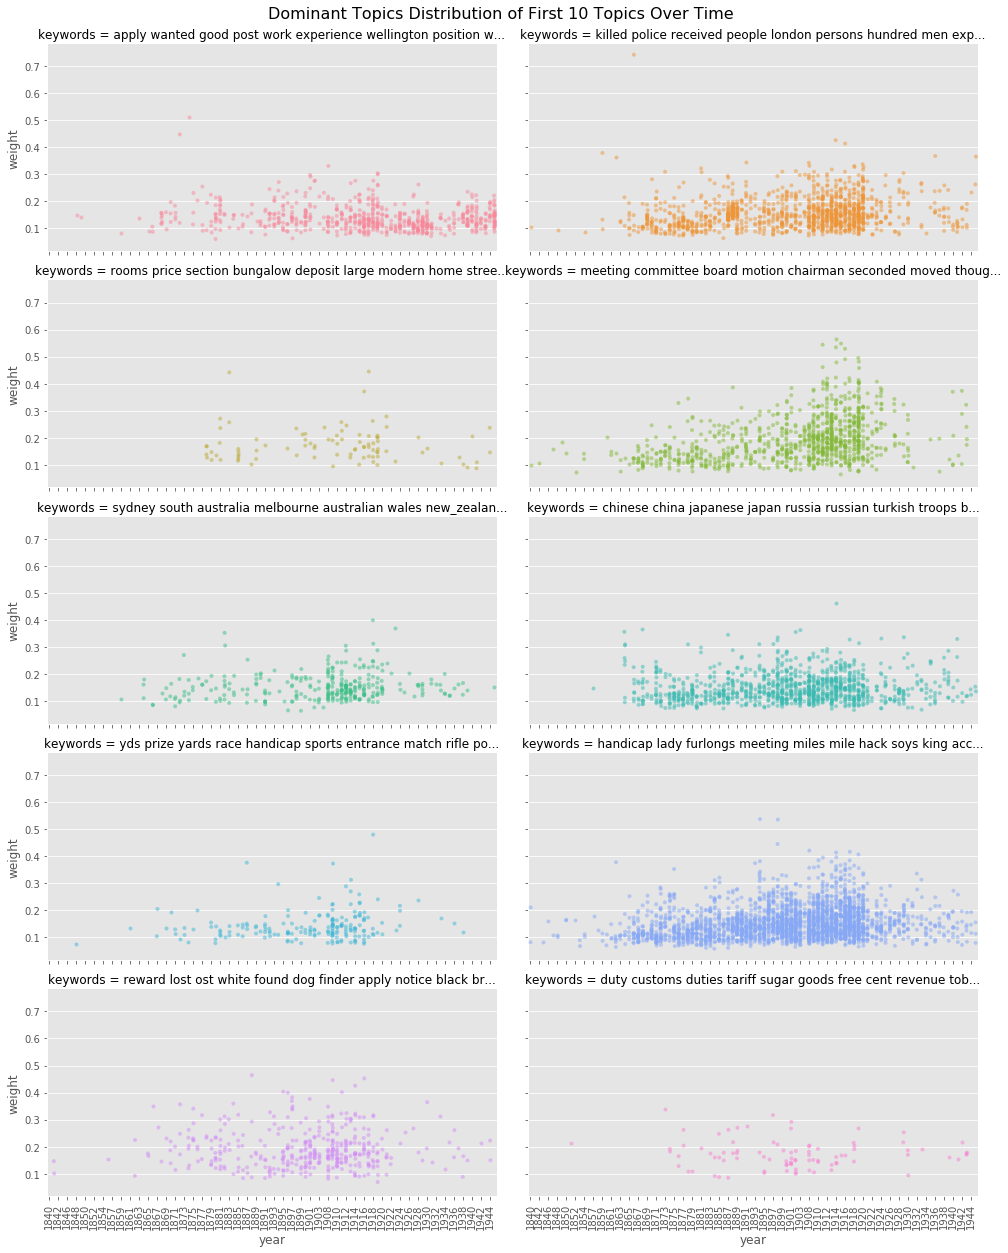

In [19]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by year:**

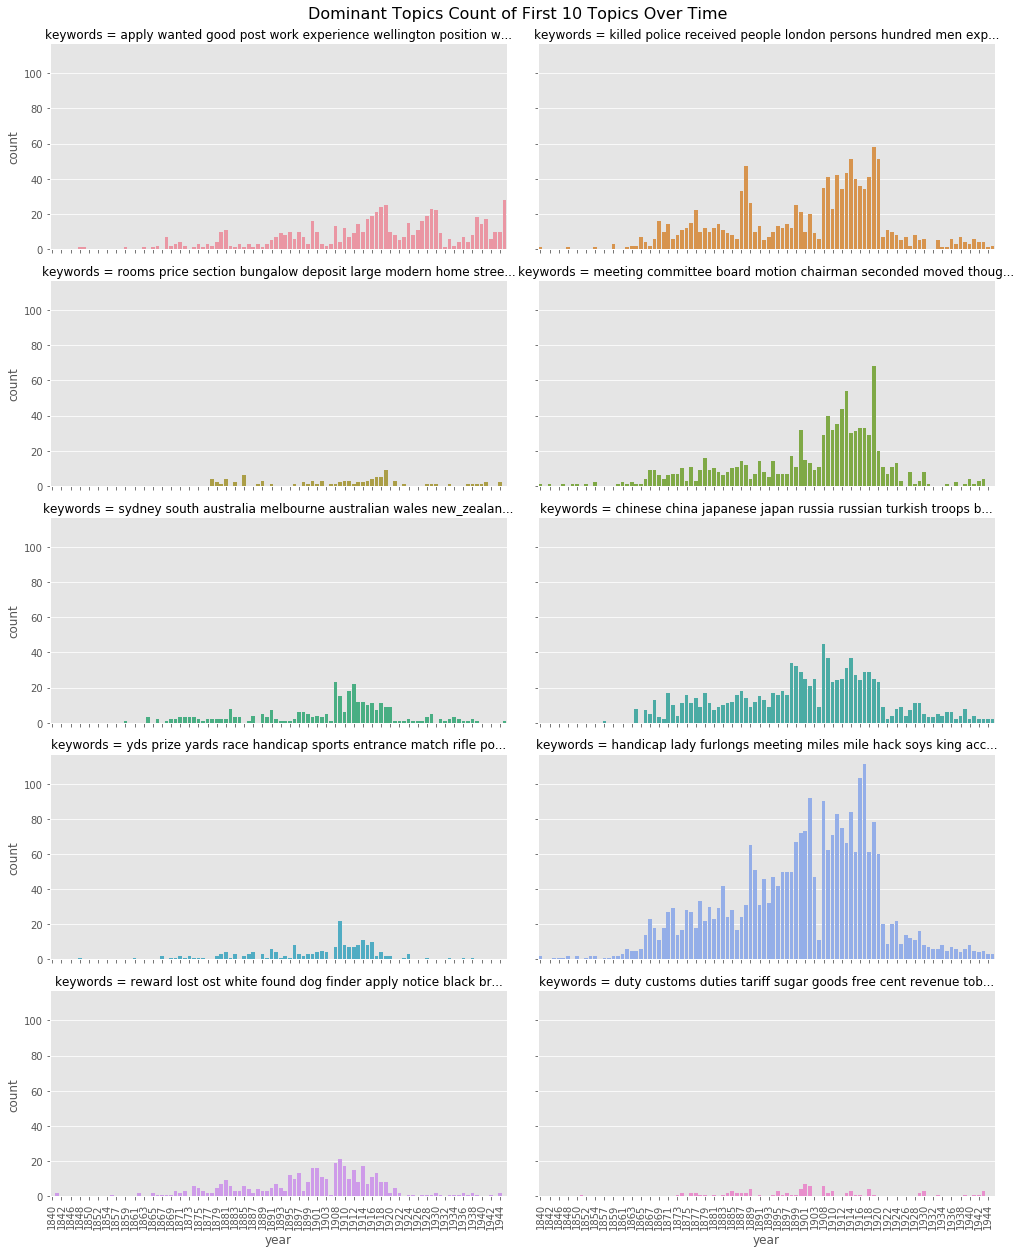

In [20]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by year:**

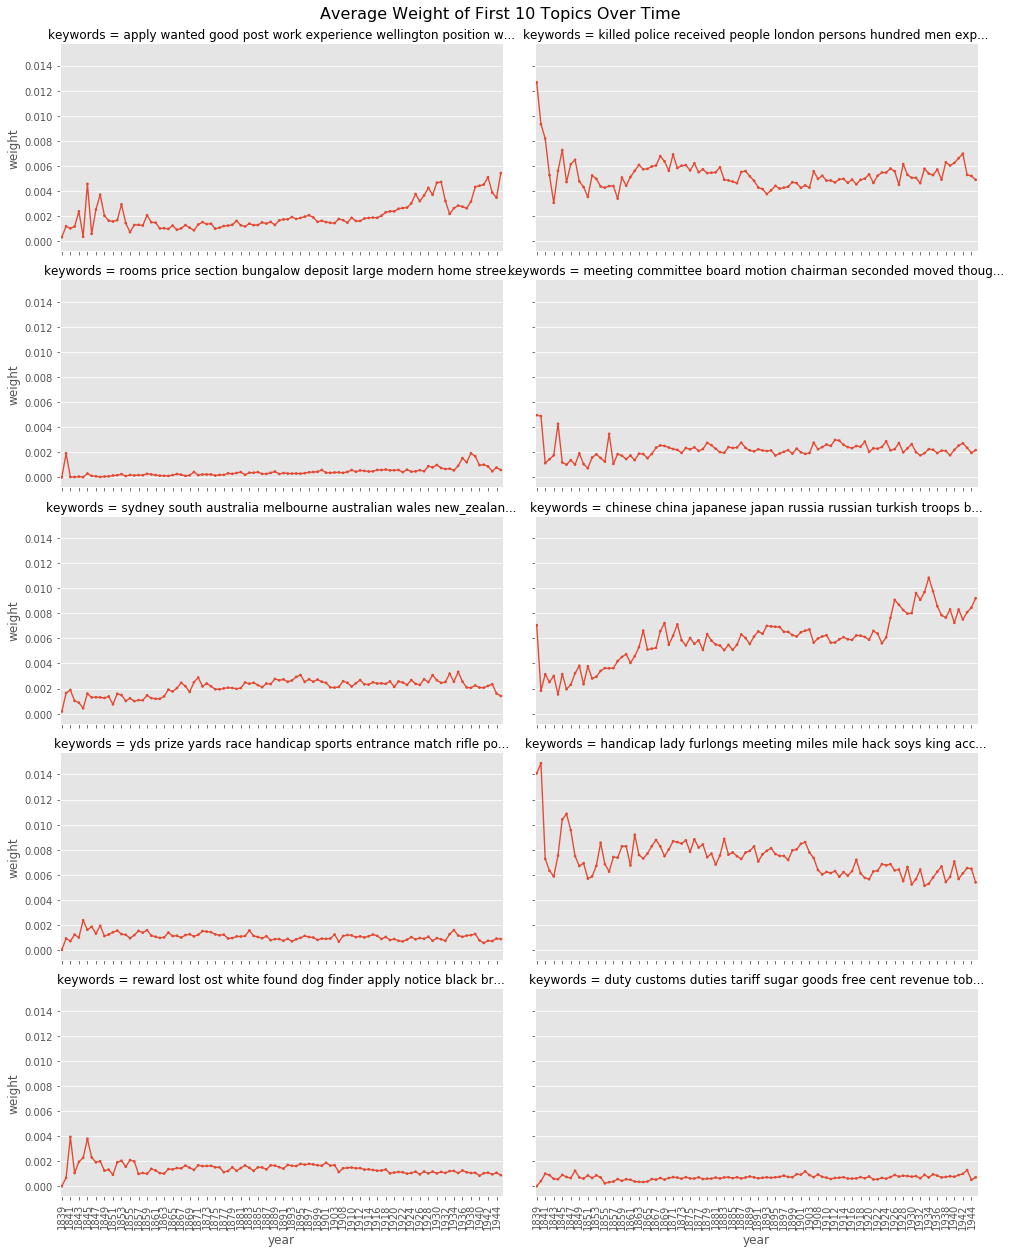

In [21]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

## 5 The Most Significant Topics

**Variance dose not consider the document number, if a topic has high variance but the support documents are few, the topic is not significant. To find significant, we use the figure that dominant topic count multiply the average weight of the topic, this figure considers both the number of support document and the average weight of topic. This way magnifies the topics that are dominant topics of documents, we take it as significant topics.**

In [22]:
df_domtopic_count = (df_domtopic.groupby(['year', 'topic'])
                     .size().reset_index(name='count')
                     .sort_values(['year', 'topic']))
df_domtopic_count.columns = ['year_', 'topic_', 'count']

df_signif = df_avgweight.copy(deep=True)

df_signif = (df_signif
             .merge(df_domtopic_count, left_on=['year', 'topic'], right_on=['year_', 'topic_'], how='outer')
             .sort_values(by=['year', 'topic'])
             .drop(columns=['keywords', 'year_', 'topic_'])
             .reset_index(drop=True)
             .fillna(0))

df_signif['value'] = df_signif['weight'] * df_signif['count']

topic_list = list(df_signif.groupby('topic')['value'].std().sort_values(ascending=False).index[:10])
signif_topic_list = topic_list

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [38, 28, 93, 136, 42, 63, 55, 146, 193, 33]
Shape of df_plt_dom: (462067, 6)
Shape of df_plt_avg: (1040, 4)


,weight,keywords
topic,,
38,0.067616,tin ill oil day lit zealand mil ton tie hat aro fur aid ail end tins man hut time win
28,0.030178,man good people time day men money make thing young put business told things made long great give back poor
93,0.026489,people country men public government law political state party man great power system question good present time pol...
136,0.025395,life man men great world work people good human time mind nature things years knowledge subject character make fact ...
42,0.021017,time question matter present fact made case position public great doubt opinion good make point part reason subject ...
63,0.021164,time back man head round left men made long feet side hand night great ground body face found place hands
55,0.016595,sale stock goods prices cash great advertisements price column drapery bargains reduced clothing sold large cheap co...
146,0.015191,colony country new_zealand great large land population present time years people means good colonies made industry n...
193,0.018363,life love god heart day thy man world great thou men death long light thee earth eyes home sweet land


**Dominant topics distribution by year:**

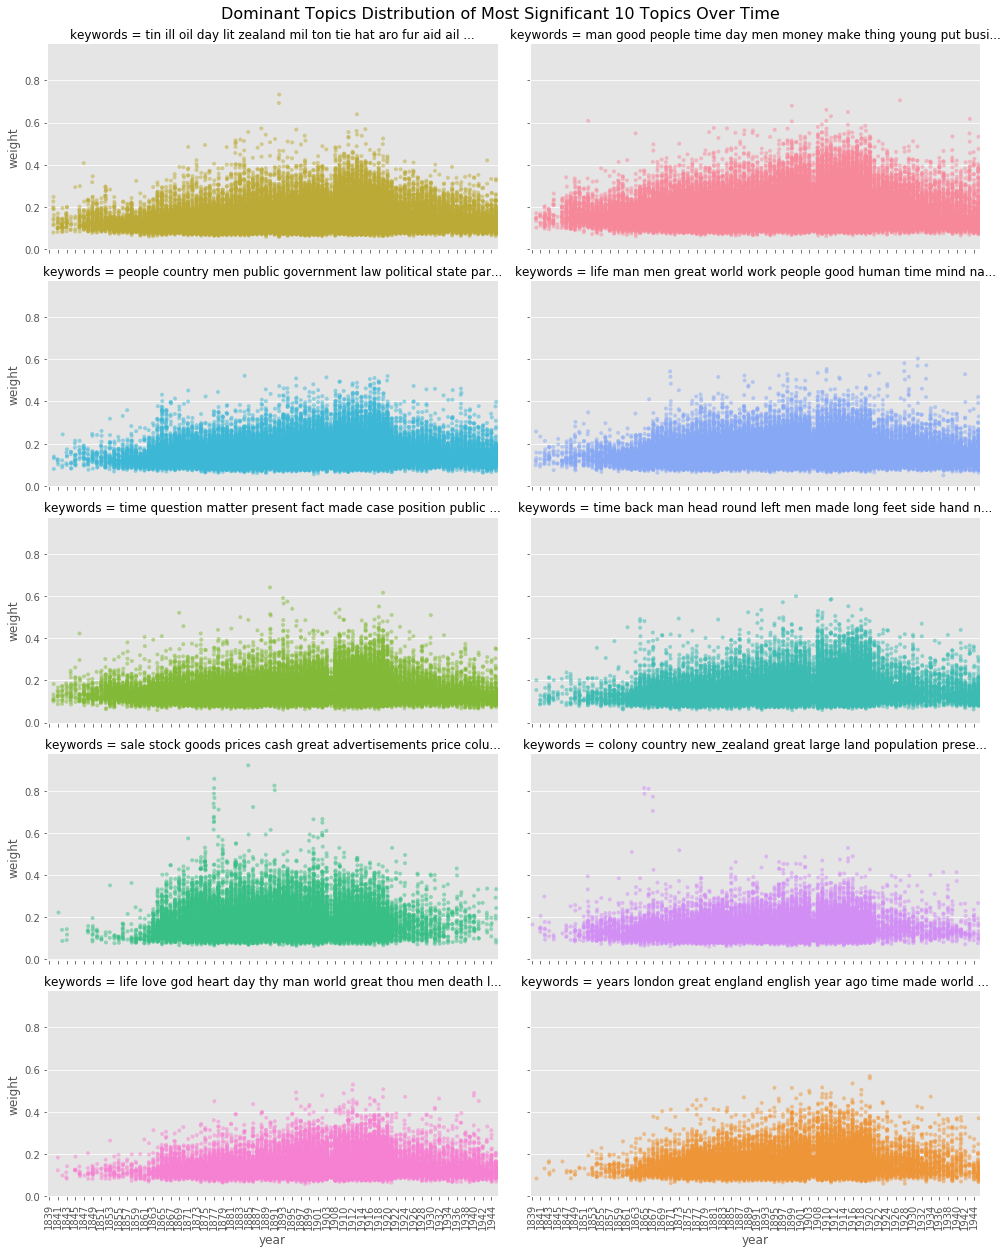

In [23]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by year:**

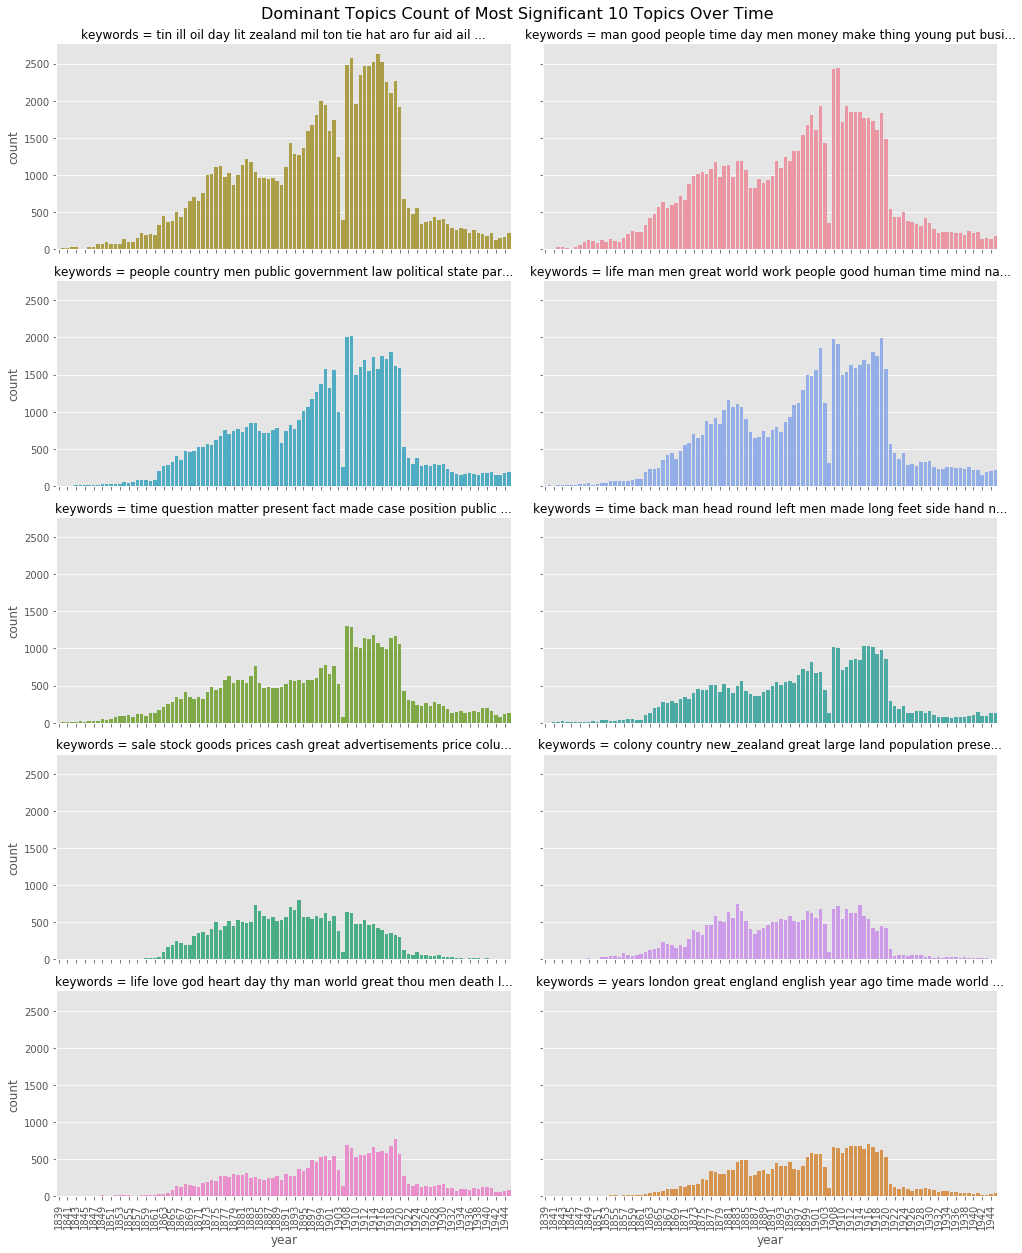

In [24]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by year:**

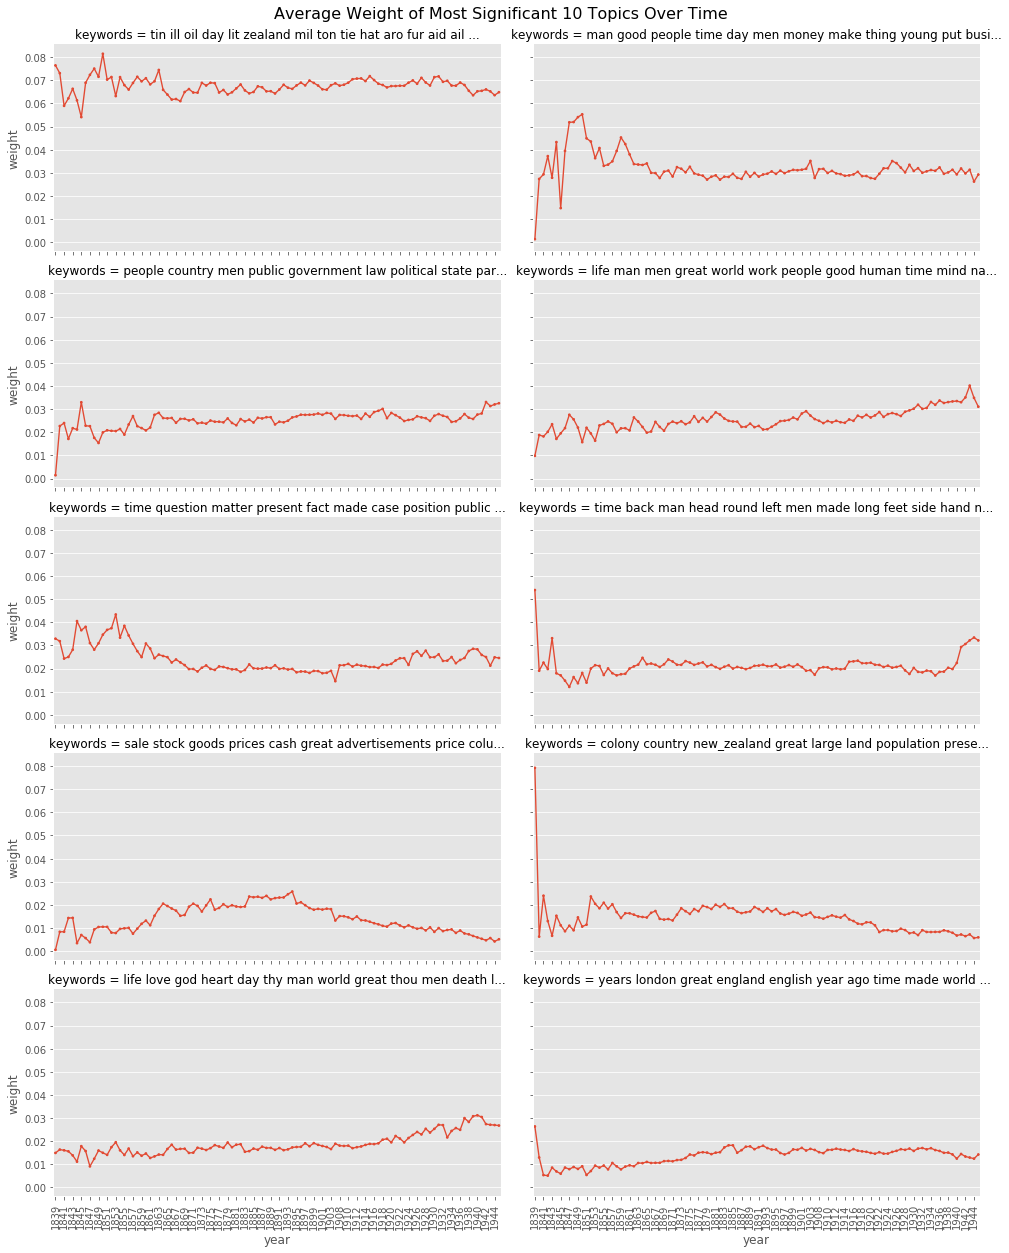

In [25]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

## 6 The Most Different Topics

**By compare the topic weight in topic list, we can find out which topics are the most different between ADs and non-ADs. Here we are interested in both trend (the more or less popular topics) in the ADs.**

In [26]:
path = r'../models/ads/topicKeysOthers.csv'

df_topics_others = (pd.read_csv(path, 
                                header=None, 
                                index_col=None, 
                                names = ['topic_', 'weight_', 'keywords_'],
                                encoding='utf8')
                    .sort_values(by='topic_')
                    .reset_index(drop=True))

df_diff = df_topics_others.join(df_topics)

# to find more populare topics
#df_diff['diff'] = (df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])
# to find more populare or contrary trend topics
df_diff['diff'] = abs(df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])

df_diff = df_diff.sort_values(by='diff', ascending=False)

topic_list = list(df_diff['topic'][:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [126, 185, 41, 171, 109, 34, 95, 102, 107, 170]
Shape of df_plt_dom: (1148, 6)
Shape of df_plt_avg: (1040, 4)


,weight,keywords
topic,,
126,0.002131,association press telegraph received copyright london united electric cable sydney april march news australian octob...
185,0.001228,wellington arrived nelson morning sailed auckland tons to-morrow port to-day lyttelton westport coast south picton l...
41,0.000431,auckland wellington left due london january december lyttelton march october april february november september sydne...
171,0.001571,german enemy germans front french london british fighting troops attack captured received russian artillery line sta...
109,0.001130,beat club played match play game championship won players tennis team games round wellington tournament matches satu...
34,0.001461,weather rain wind winds heavy moderate hours strong barometer light gale to-day cape forecast breeze sea morning sou...
95,0.001092,minister government hon sir ward prime joseph massey house made new_zealand wellington party deputation country matt...
102,0.000643,stock bank buyers sellers new_zealand national sales pref insurance cent wellington ord auckland waihi exchange shar...
107,0.000770,school education schools board children teachers boys teacher committee high girls pupils work district parents tech...


**Dominant topics distribution by year:**

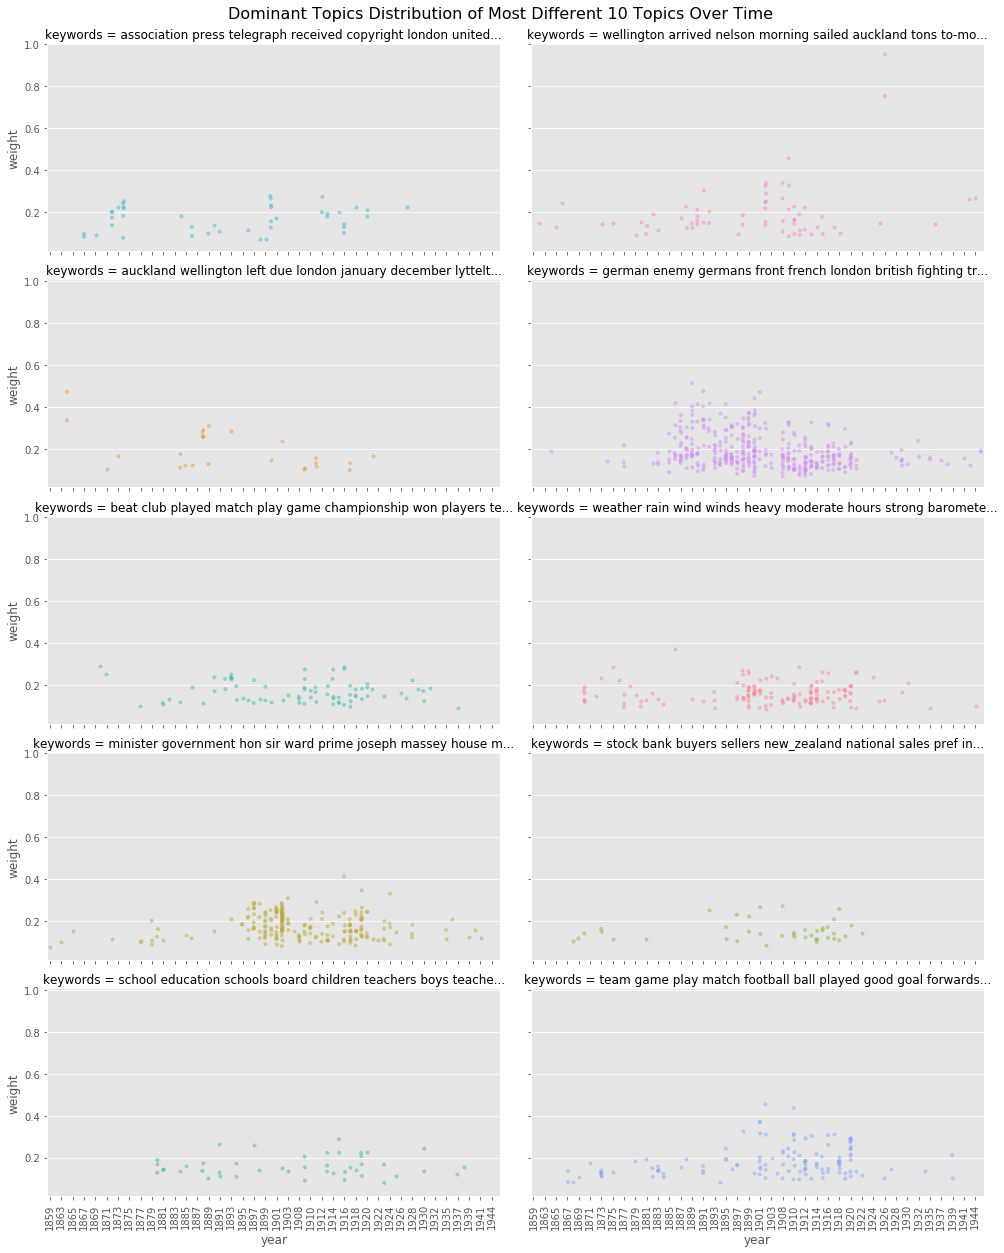

In [27]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by year:**

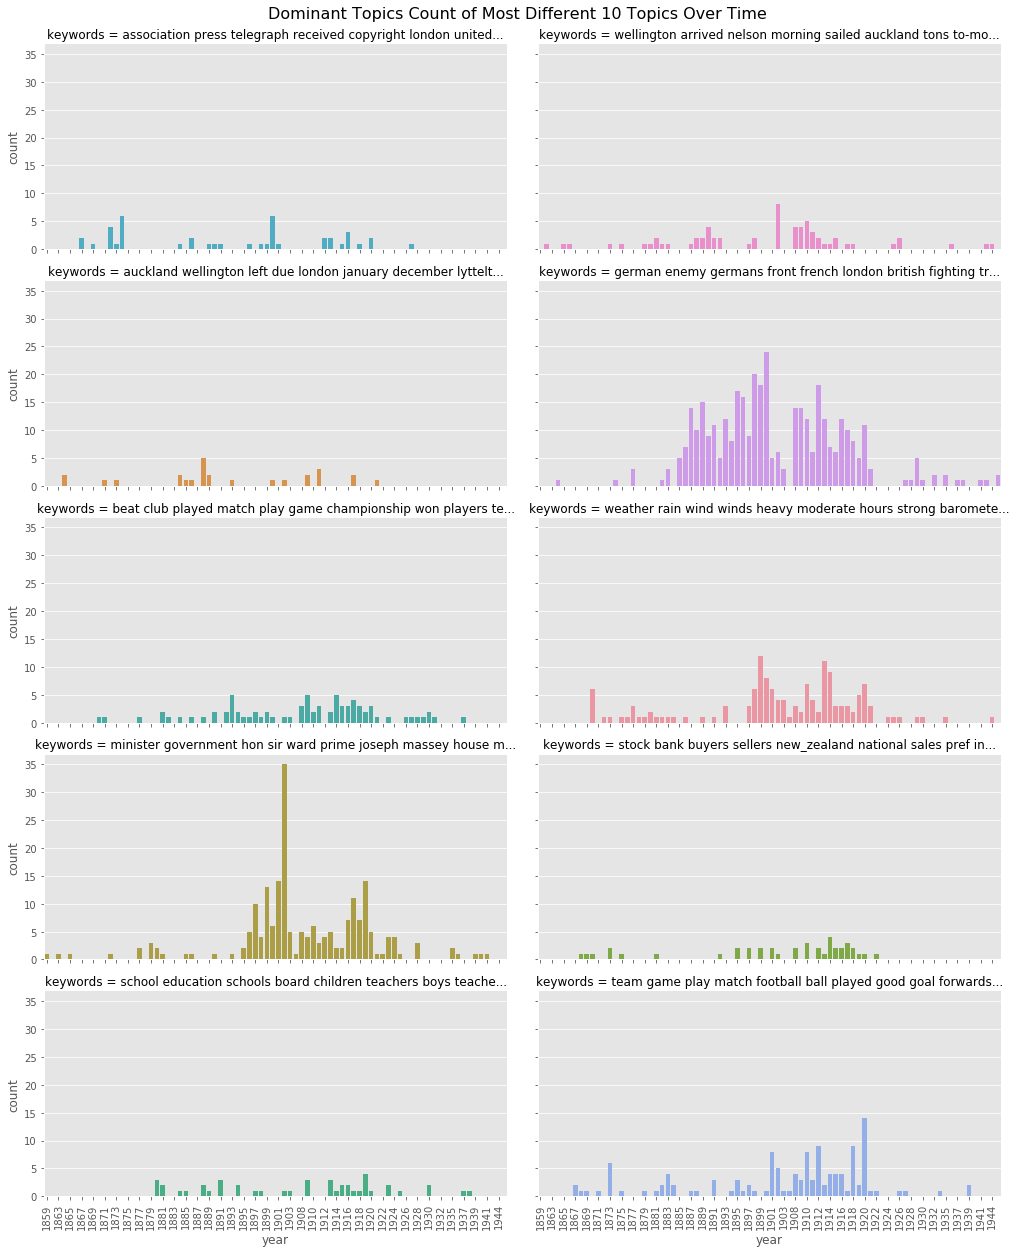

In [28]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by year:**

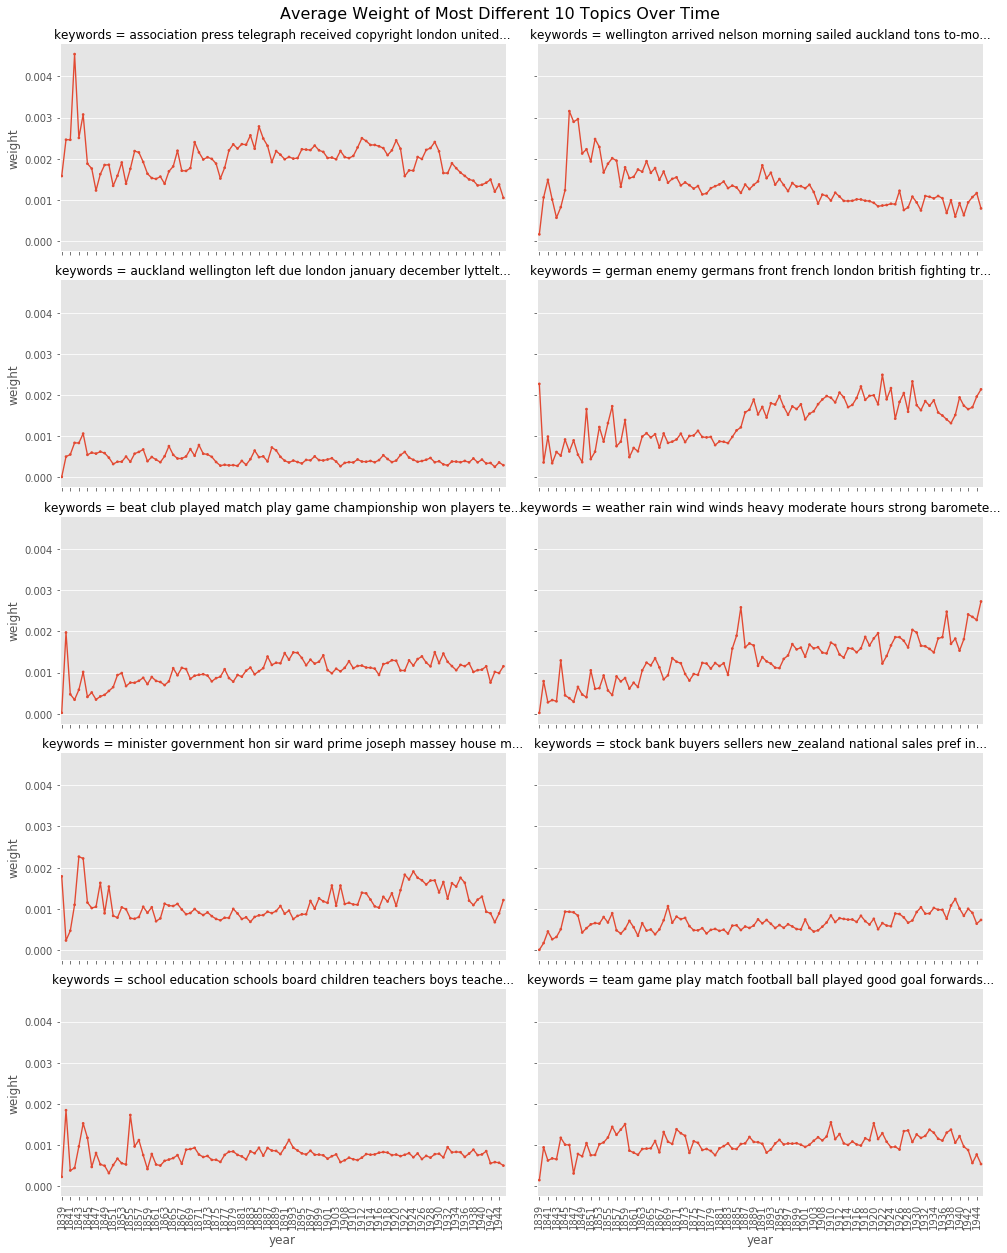

In [29]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Different 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

---

In [30]:
gc.collect()

22